In [1]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from lightning.pytorch import seed_everything
from pathlib import Path
from skimage.io import imread

import torch
torch.set_float32_matmul_precision("high")
  
seed_everything(1337)
scvi.settings.seed = 1337

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 1337
Seed set to 1337


In [4]:
# Info
whatFer = "two"# which Layered analysis?

#Load data
adata_file = Path(f"/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/CAR_T/CellCharterAnalysis/twofer/{whatFer}fer.h5ad")
ST_sample = sc.read_h5ad(adata_file)

/tmp/ipykernel_1872/2050882012.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["mouse", "cluster_cellcharter"])


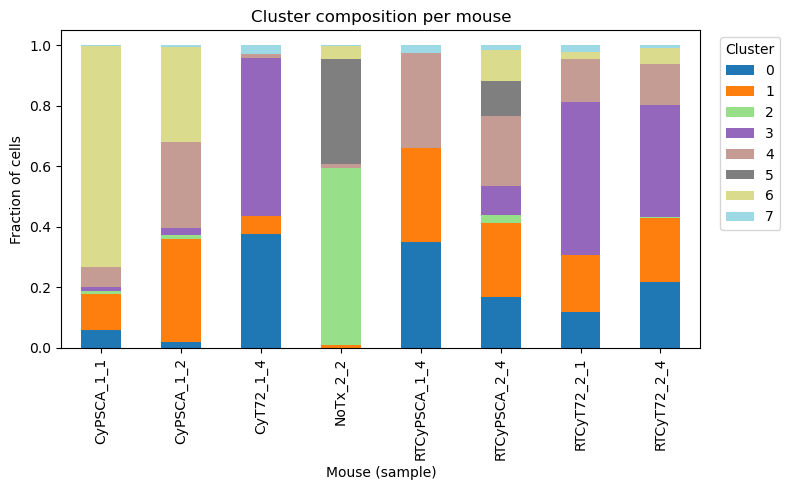

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Count cells per (mouse, cluster)
#    Use 'mouse' if you want each biological sample separately.
df_counts = (
    ST_sample.obs
    .groupby(["mouse", "cluster_cellcharter"])
    .size()
    .reset_index(name="n_cells")
)

# Pivot so that rows = mouse, columns = cluster, values = n_cells
df_pivot = df_counts.pivot(index="mouse",
                            columns="cluster_cellcharter",
                            values="n_cells").fillna(0)

# Convert counts → fractions (sum over clusters per mouse)
df_frac = df_pivot.divide(df_pivot.sum(axis=1), axis=0)

# Plot as a stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
df_frac.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")
ax.set_ylabel("Fraction of cells")
ax.set_xlabel("Mouse (sample)")
ax.set_title("Cluster composition per mouse")
ax.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Neighborhood_enrichment

In [13]:
ST_sample.obsp

PairwiseArrays with keys: spatial_connectivities, spatial_distances

In [27]:
cc.gr.nhood_enrichment(
    ST_sample,
    cluster_key="cluster_cellcharter",
    connectivity_key="spatial", #Why does it add _connectivities?!?! weird.
    symmetric=False,         # asymmetric by default (enrichment i→j ≠ j→i)
    only_inter=True,         # count only links between different clusters
    pvalues=True,           # no permutations/p-values (fast, analytical)
    observed_expected=False, # only keep final enrichment, not the raw observed/expected
    copy=False               # write results into ST_sample.uns under "cluster_cellcharter_nhood_enrichment"
)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.26it/s]


In [19]:
ST_sample.obs['condition'].unique()

['RTCyT72', 'RTCyPSCA', 'CyPSCA', 'NoTx', 'CyT72']
Categories (5, object): ['CyPSCA', 'CyT72', 'NoTx', 'RTCyPSCA', 'RTCyT72']

In [26]:
ST_sample.uns

{'_scvi_manager_uuid': '3c225d3d-90f4-4cb6-922e-f69e7bba1d8d',
 '_scvi_uuid': '449325a0-1869-414c-a13c-5d805191ea43',
 'cluster_cellcharter_colors': array(['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f',
        '#e5c494', '#b3b3b3'], dtype=object),
 'condition_colors': array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
       dtype=object),
 'log1p': {},
 'spatial': {'F07839': {'images': {'hires': array([[[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 255],
            [255, 255, 255]],
    
           [[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 255],
            [255, 255, 255]],
    
           [[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 255],
            [255

/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jon/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


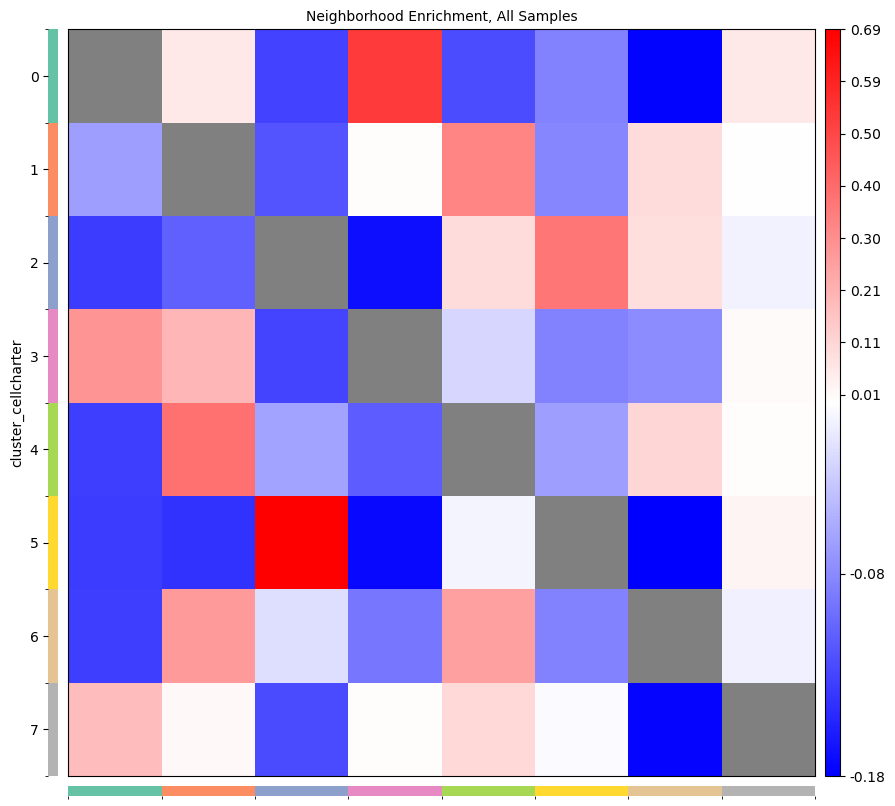

In [34]:
cc.pl.nhood_enrichment(
    ST_sample,
    cluster_key="cluster_cellcharter",
    title="Neighborhood Enrichment, All Samples"
)

KeyError: 'cluster_cellcharter_condition_diff_nhood_enrichment'

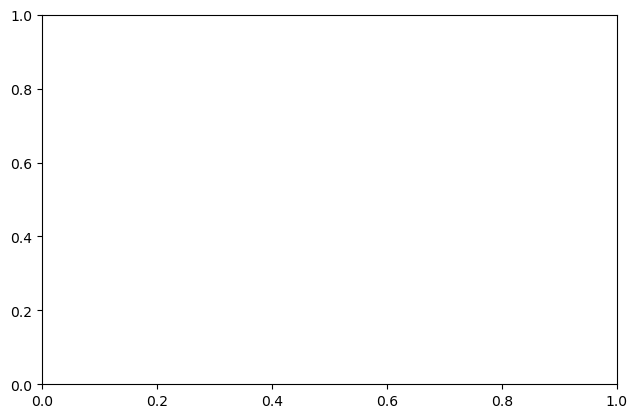

In [7]:
for condition in ["RTCyT72", "RTCyPSCA", "CyPSCA", "CyT72"]:
    cc.pl.diff_nhood_enrichment(
        ST_sample,
        cluster_key="cluster_cellcharter",
        condition_key="condition",
        condition_groups=[condition, "NoTx"],
        title=f"{condition} vs NoTx",
        ncols=1,
    )
